In [1]:
%store -r car_data_updated
%store -r categorical_columns
%store -r numerical_columns
%store -r car_data
%store -r car_data_updated_1

# Preprocessing

The objective of this project is to build models to predict the price of car as a function of features that define a car and and to study how the variation of the different features affect the price of the car

The purpose of this notebook is to use an algorithm to define a initial baseline to compare to other more powerful algorithms.

Table of Contents

[d.1 Train/test split](#d.1)

[d.2 Standard scaling](#d.2)

[d.3 Linear regression with cross-validation](#d.3)

[d.4 Lasso and Ridge Regression](#d.4)

[d.5 Metrics Evaluation on Test Set](#d.5)

In [2]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy import stats

<a id="d.1"></a>
## d.1 Train/test split

In [23]:
from sklearn.model_selection import train_test_split

# Define the features and the target
#X = car_data_encoded.drop('price', axis=1)
#y = car_data_encoded['price']

# Define the features and the target
X = car_data_updated_1.drop(['price', 'car_ID',  'symboling','cluster'], axis=1)
y = car_data_updated_1['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [31]:
X_train.shape, y_train.shape,X_test.shape,y_test.shape

((153, 18), (153,), (52, 18), (52,))

In [24]:
# Displaying data types of all columns
column_data_types = X_train.dtypes

# Analyze each column to categorize them
categorical_columns = []
numerical_columns = []

for column, dtype in column_data_types.items():
    if dtype == 'object':
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

# Print the results
print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'CompanyName']

Numerical Columns:
['carheight', 'boreratio', 'stroke', 'compressionratio', 'peakrpm', 'carsize', 'fuelefficiency', 'carpower']


<a id="d.2"></a>
## d.2 Standard scaling

In [37]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Apply One-Hot Encoding to categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_encoded_categorical = ohe.fit_transform(X_train[categorical_columns])  # Example categorical columns
X_test_encoded_categorical = ohe.transform(X_test[categorical_columns])

# Convert encoded data to DataFrame
encoded_columns = ohe.get_feature_names_out(categorical_columns)
X_train_encoded_categorical_df = pd.DataFrame(X_train_encoded_categorical.toarray(), columns=encoded_columns)
X_test_encoded_categorical_df = pd.DataFrame(X_test_encoded_categorical.toarray(), columns=encoded_columns)

# Reset index of encoded categorical DataFrames to align with numerical data
X_train_encoded_categorical_df.reset_index(drop=True, inplace=True)
X_test_encoded_categorical_df.reset_index(drop=True, inplace=True)

# Scale the numerical columns
scaler = StandardScaler(with_mean=False)  # Set with_mean to False
X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_numerical_scaled = scaler.transform(X_test[numerical_columns])

# Convert the scaled numerical arrays back to DataFrames
X_train_numerical_scaled_df = pd.DataFrame(X_train_numerical_scaled, columns=numerical_columns)
X_test_numerical_scaled_df = pd.DataFrame(X_test_numerical_scaled, columns=numerical_columns)

# Combine categorical and numerical data
X_train_encoded = pd.concat([X_train_encoded_categorical_df, X_train_numerical_scaled_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded_categorical_df, X_test_numerical_scaled_df], axis=1)

# Get the column names
column_names = X_test_encoded.columns.tolist()


In [42]:
X_train_encoded.head()

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,...,CompanyName_volkswagen,CompanyName_volvo,carheight,boreratio,stroke,compressionratio,peakrpm,carsize,fuelefficiency,carpower
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,22.153573,11.062251,11.415816,5.854433,9.826730,16.749890,5.271732,2.041103
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,22.316168,12.246171,11.646107,2.325734,8.598389,17.831697,3.031562,2.764531
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.747085,11.654211,10.823642,2.512862,10.645624,17.003519,3.760400,2.144449
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,21.584490,11.802201,11.185526,2.272269,11.259795,17.774759,1.964418,3.177919
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,21.137354,13.393093,11.514512,2.486129,9.826730,17.609124,2.379555,3.384613


In [38]:
X_train_encoded.shape, X_test_encoded.shape, y_train.shape, y_test.shape

((153, 66), (52, 66), (153,), (52,))

<a id="d.3"></a>
## d.3 Linear regression with cross-validation

In [92]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Define the K-Fold Cross-Validator
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store scores
total_rmse_test = 0
total_rmse_train = 0

# Perform K-Fold Cross-Validation on the training data
for train_index, test_index in kf.split(X_train_encoded):
    # Split data into training and testing sets for this fold
    X_train_kf, X_test_kf = X_train_encoded.iloc[train_index], X_train_encoded.iloc[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]
    
    # Fit the model to the training data
    linear_model.fit(X_train_kf, y_train_kf)
    
    # Make predictions on the test data
    predictions_test = linear_model.predict(X_test_kf)
    predictions_train = linear_model.predict(X_train_kf)
    
    # Calculate RMSE for this fold
    rmse_test = mean_squared_error(y_test_kf, predictions_test, squared=False)
    rmse_train = mean_squared_error(y_train_kf, predictions_train, squared=False)  # Training RMSE
    
    # Accumulate total RMSE
    total_rmse_test += rmse_test
    total_rmse_train += rmse_train

# Calculate and print the average RMSE across all folds
average_rmse_test = total_rmse_test / k
average_rmse_train = total_rmse_train / k
print(f"Average RMSE across {k} folds (Cross-Validation) - Test: {average_rmse_test}")
print(f"Average RMSE across {k} folds (Cross-Validation) - Train: {average_rmse_train}")

# Fit the model on the entire training set
linear_model.fit(X_train_encoded, y_train)

# Make predictions on the testing set
y_pred = linear_model.predict(X_test_encoded)
preds_linear=y_pred



Average RMSE across 5 folds (Cross-Validation) - Test: 1242301355346651.2
Average RMSE across 5 folds (Cross-Validation) - Train: 1236.657244813089


Since the Training RMSE is a lot smaller compared to the Testing RMSE, it indicates the potential overfitting.

<a id="d.4"></a>
## d.4 Lasso and Ridge Regression

In [94]:
# Lasso Regrssion with Cross-Validation
from sklearn.linear_model import LassoCV

# List of alphas to try out
alphas = np.logspace(-4, 4, 20)

# Lasso Regression with Cross-Validation
lasso_cv = LassoCV(alphas=alphas, cv=5)  # 5-fold cross-validation
lasso_cv.fit(X_train_encoded, y_train)

# Optimal alpha and corresponding RMSE
optimal_lasso_alpha = lasso_cv.alpha_
preds_lasso = lasso_cv.predict(X_test_encoded)
lasso_cv_rmse = mean_squared_error(y_test, preds_lasso, squared=False)

print("Optimal Lasso Alpha:", optimal_lasso_alpha)
print("Lasso Testing RMSE with Optimal Alpha:", lasso_cv_rmse)

Optimal Lasso Alpha: 11.288378916846883
Lasso Testing RMSE with Optimal Alpha: 2755.8724168260073


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5128043.397612274, tolerance: 805425.9593346312
  model = cd_fast.enet_coordinate_descent_gram(


In [95]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV

# Ridge Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)  # 5-fold cross-validation
ridge_cv.fit(X_train_encoded, y_train)

# Optimal alpha and corresponding RMSE
optimal_ridge_alpha = ridge_cv.alpha_
preds_ridge = ridge_cv.predict(X_test_encoded)
ridge_cv_rmse = mean_squared_error(y_test, preds_ridge, squared=False)

print("Optimal Ridge Alpha:", optimal_ridge_alpha)
print("Ridge Testing RMSE with Optimal Alpha:", ridge_cv_rmse)

Optimal Ridge Alpha: 0.615848211066026
Ridge Testing RMSE with Optimal Alpha: 2613.3004447508


With Lasso and Ridge, the gap between training and testing error is reduced a lot compared to the simple linear regression. Therefore, regularization does help to mitigate overfitting.

<a id="d.5"></a>
## d.5 Metrics Evaluation on Test Set

In [96]:
def calculate_regression_metrics(y_true, y_pred, X_data):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r_squared = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X_data.shape[1]
    adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, adjusted_r_squared, mape

# Calculate metrics for Lasso
lasso_metrics = calculate_regression_metrics(y_test, preds_lasso, X_test_encoded)
print("Lasso RMSE:", lasso_metrics[0])
print("Lasso Adjusted R-squared:", lasso_metrics[1])
print("Lasso MAPE:", lasso_metrics[2], "%")

# Calculate metrics for Ridge
ridge_metrics = calculate_regression_metrics(y_test, preds_ridge, X_test_encoded)
print("Ridge RMSE:", ridge_metrics[0])
print("Ridge Adjusted R-squared:", ridge_metrics[1])
print("Ridge MAPE:", ridge_metrics[2], "%")


Lasso RMSE: 2755.8724168260073
Lasso Adjusted R-squared: 1.3816525006643423
Lasso MAPE: 15.07987182405817 %
Ridge RMSE: 2613.3004447508
Ridge Adjusted R-squared: 1.3431852241333415
Ridge MAPE: 14.879700805943042 %


There seems to be a positive linear relationship between the actual and predicted values, as indicated by the points generally following the dashed line, which represents a great fit.
There are some points far from the dashed line, indicating instances where the model's predictions are quite far from the actual values.
For higher values of the actual target variable, the model appears to be less accurate, with predictions deviating more from the line.

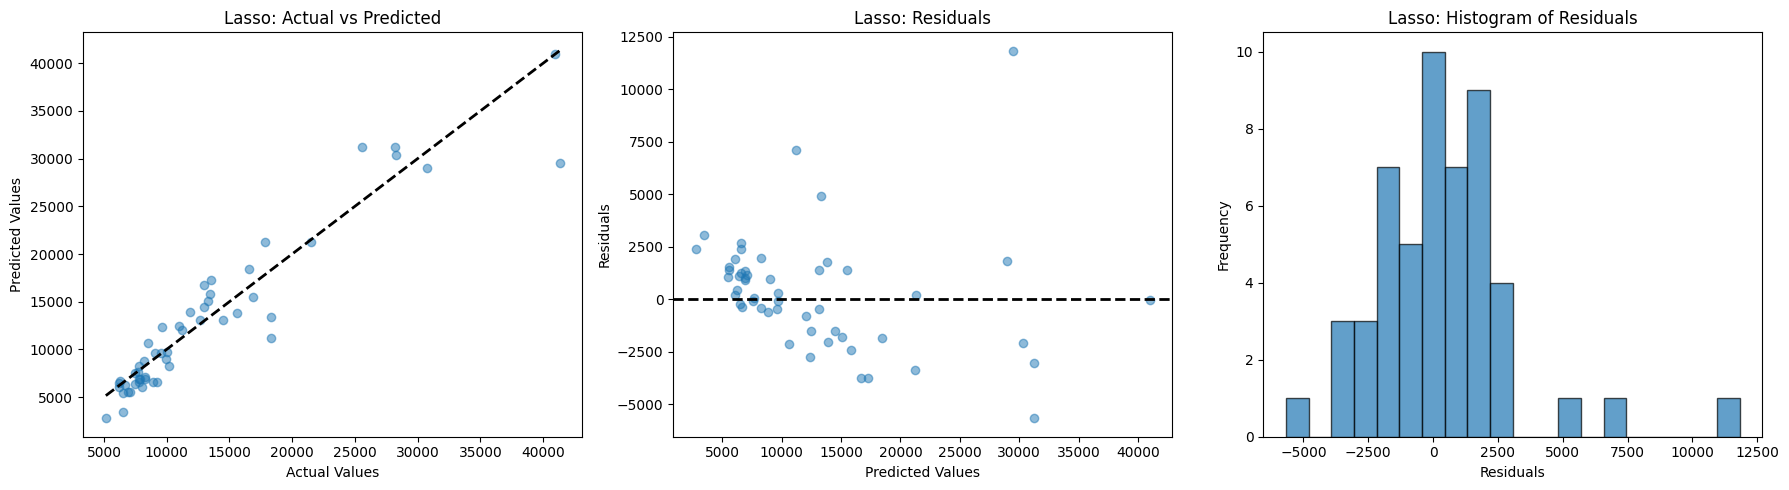

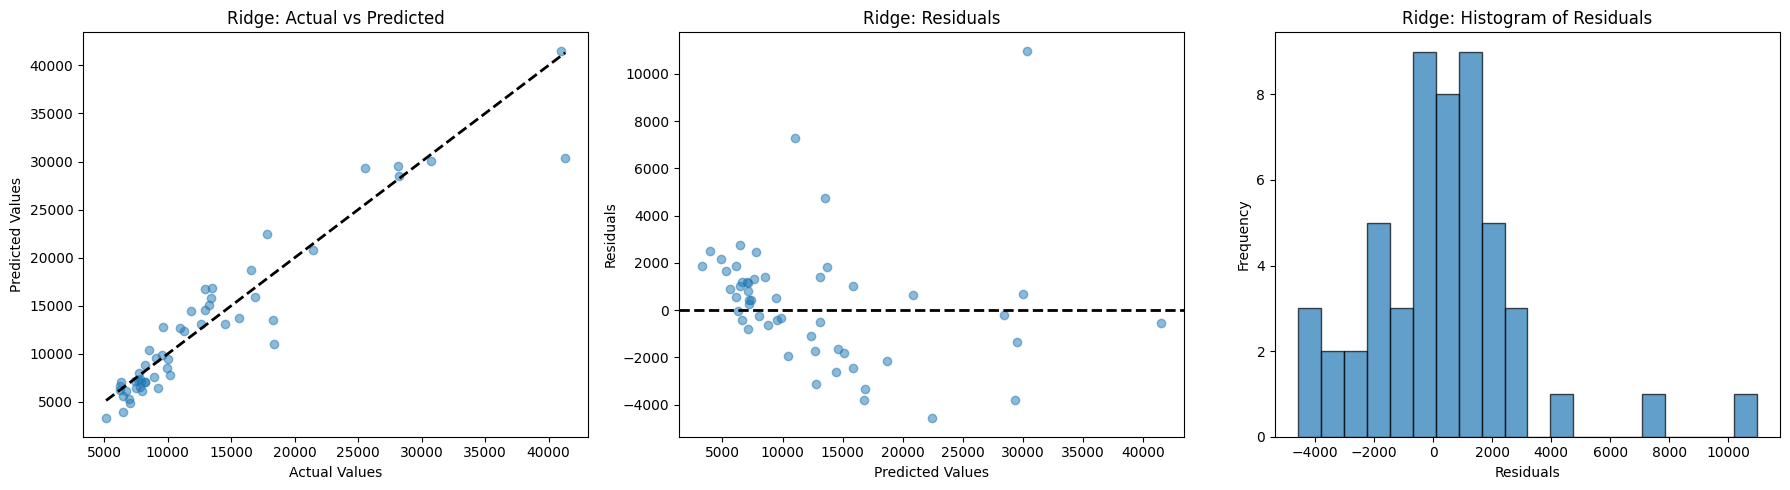

In [98]:
# Function to plot scatter, residuals, and histogram
def plot_model_performance(y_test, y_pred, model_name):
    residuals = y_test - y_pred

    plt.figure(figsize=(18, 5))

    # Scatter plot
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Residuals plot
    plt.subplot(1, 3, 2)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.title(f'{model_name}: Residuals')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='k', linestyle='--', lw=2)

    # Histogram of residuals
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'{model_name}: Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot for Lasso
plot_model_performance(y_test, preds_lasso, "Lasso")

# Plot for Ridge
plot_model_performance(y_test, preds_ridge, "Ridge")


Overall, both models seem to perform similarly, with a tendency to underpredict at higher values. The presence of patterns in the residuals plot and the heavy tails in the histograms suggest that there might be some systematic bias in the models or that the models might not be capturing all the complexity of the underlying data. This could be due to non-linear relationships that are not well represented by these linear models, or possibly influential outliers that are affecting model performance. Regularization, such as that applied by Lasso and Ridge, helps with overfitting but doesn't necessarily address all forms of model bias or underfitting.

Summary

Based on the provided plots, the Lasso and Ridge models seem to be doing a reasonable job of capturing the relationship between the predictors and the target variable, with some potential issues with outliers and heteroscedasticity at higher value ranges. It would be beneficial to investigate additional modeling algorithms, such as random forests, LGBM etc.

In [88]:
%store X_train_encoded
%store X_test_encoded
%store y_train
%store y_test
%store column_names
%store preds_linear
%store preds_lasso
%store preds_ridge
from joblib import dump
models={'model1':lasso_cv, 'model2':ridge_cv}
dump(models, 'all_models_filename.joblib')

Stored 'X_train_encoded' (DataFrame)
Stored 'X_test_encoded' (DataFrame)
Stored 'y_train' (ndarray)
Stored 'y_test' (Series)
Stored 'column_names' (list)
Stored 'preds_linear' (ndarray)
Stored 'preds_lasso' (ndarray)
Stored 'preds_ridge' (ndarray)


['all_models_filename.joblib']